### The input is a file with format: timestamp, personId, x, y

In [ ]:
#change the center to be in the middle of the field. randomized to be implemented

In [162]:
import numpy as np
init_timestamp = 1436047260000
beta = (60/55)*60*1000 # in ms, according to the paper Freudiger 2015, time delay between packets
sigma_est = 3
half_dist_teleport =10
sigma_teleport = 2
measurement_delay = 500 # in ms

In [129]:
def generate_first_moment_visible(crowd_size): #initialization      
    next_moment =[]
    for i in range(0, crowd_size):
        delay = np.random.exponential(beta)
        next_moment.append(int(init_timestamp  + delay))    
    return next_moment    

In [130]:
next_moment = generate_first_moment_visible(3)
next_moment

[1436260379, 1436126259, 1436086695]

In [131]:
def gen_next_moment(timestamp_now): # next moment is drawn from exponential(1/beta) distribution
    delay = np.random.exponential(beta)
    return int(timestamp_now + delay) + 1# avoid 0

In [132]:
next_mom = gen_next_moment(3)

In [133]:
next_mom

1733

In [160]:
def make_new_record(record, new_position, randomized):#record = [timestamp, personId, x, y], new_position = [x,y]
    sigma_x =  np.random.exponential(sigma_est)
    sigma_y =  np.random.exponential(sigma_est)
    new_record = {}
    new_record["measurementTimestamp"] = record[0]
    new_record["value"] = {}
    new_record["value"]["sourceMac"] = record[1]
    new_record["value"]["averagecoordinate"] = {}
    new_record["value"]["averagecoordinate"]["avg"] = {}
    new_record["value"]["averagecoordinate"]["avg"]["coordinates"] =[new_position[0], new_position[1], 0.0]
    new_record["value"]["averagecoordinate"]["error"] = {}
    new_record["value"]["averagecoordinate"]["error"]["coordinates"] = [sigma_x, sigma_y, 1000.0]#in the real data for z is 1000
    new_record["value"]["trackeeHistory"]={}
    new_record["value"]["trackeeHistory"]["localMac"] = randomized
    return new_record

In [135]:
b = make_new_record([0,1,3,4], [5,6], 0)

In [136]:
b

{'measurementTimestamp': 0,
 'trackeeHistory': {'localMac': 0},
 'value': {'averagecoordinate': {'avg': {'coordinates': [5, 6, 0.0]},
   'error': {'coordinates': [1.6502504266277618, 6.675487490542074, 1000.0]}},
  'sourceMac': 1}}

In [137]:
def generate_randomized(crowd_size): #to be done
    randomized = [0 for i in range(0, crowd_size)]
    return randomized

In [138]:
randomized = generate_randomized(6)

In [139]:
randomized


[0, 0, 0, 0, 0, 0]

In [140]:
def draw_new_coordinate(position, modes_half_distance=10.0, sigma=5.0):
    rand_mode = np.random.rand()
    if rand_mode >= 0.5:
        rand_mode = 1
    else: 
        rand_mode = -1
    mu = position + rand_mode*modes_half_distance
    new_pos = np.random.normal(mu, sigma)
    return new_pos
    

In [141]:
def create_teleportation_effect_single(record, modes_half_distance, sigma):            
        record_x = draw_new_coordinate(record[2], modes_half_distance, sigma)
        record_y = draw_new_coordinate(record[3], modes_half_distance, sigma)
        return [record_x, record_y]

In [142]:
def make_fake_data(crowd_size, positions):
    json = {}
    timestamp = init_timestamp    
    next_moment = generate_first_moment_visible(crowd_size)
    randomized = generate_randomized(crowd_size)
    fake_positions = []
    for record in positions: #record = [timestamp, personId, x, y]
        person = record[1]        
        timestamp = record[0]
        if next_moment[person] >= timestamp-measurement_delay and next_moment[person] <= timestamp:#timestamp
                new_position = create_teleportation_effect_single(record, half_dist_teleport, sigma_teleport)#[x,y]
                fake_record = make_new_record(record, new_position, randomized[person])
                fake_positions.append(fake_record)                
                next_moment[i] = gen_next_moment(next_moment[i])
    return fake_positions            

In [167]:
from scipy.stats import norm
def create_positions(init_timestamp, crowd_size, time_interval, width_stadium, length_stadium):
    positions = []    
    i = 0
    delta =0.25  #for the brownian motion, how many meters per dt:
    dt = measurement_delay
    for person in range(0, crowd_size):#initialize randomly
            positions.append([init_timestamp, person, (np.random.rand() -0.5)*width_stadium, (np.random.rand() -0.5)* length_stadium])
    for timestamp in range(0, time_interval, measurement_delay):
        for person in range(0, crowd_size):
            old_position = positions[i-crowd_size]
            old_x = old_position[2]
            old_y = old_position[3]
            new_x = old_x + norm.rvs(scale=delta**2*dt)
            new_y = old_y + norm.rvs(scale=delta**2*dt)
            if (abs(new_x) < width_stadium*0.5 and abs(new_y) < length_stadium*0.5):
                positions.append([init_timestamp+ timestamp, person, new_x, new_y])    
            else:
                positions.append([init_timestamp+ timestamp, person, old_x, old_y])
            i+=1
    return positions 

In [158]:
import json

def write_positions(positions,filename):
    file = open(filename, 'w')
    file.close()
    with open(filename, 'a') as outfile:
        for record in positions:
            json.dump(record, outfile)  
            outfile.write("\n")
        

In [168]:
crowd_size = 10000
for i in range(0,1):
    crowd_size = crowd_size*2
    positions = create_positions(init_timestamp, crowd_size, 300*1000 , 105, 68)
    fake_positions = make_fake_data(crowd_size, positions)
    write_positions(fake_positions, "F:/Arena_sim_data/positions_size_" + str(crowd_size)+".json")        

In [ ]:
crowd_size = 5
positions = create_positions(init_timestamp, crowd_size, 10*1000 , 105, 68)#this will come from Menge actually
beta = 3

In [ ]:
positions[0]

In [ ]:
fake_positions = make_fake_data(crowd_size, positions)

In [ ]:
fake_positions

In [ ]:
np.random.rand()

In [ ]:
#positions =  create_positions(10, 2, 105, 68)

In [ ]:
print(positions)

In [12]:
def create_teleportation_effect(positions, modes_distance, sigma):
    for record in positions:
        record[2] = draw_new_coordinate(record[2], modes_distance, sigma)
        record[3] = draw_new_coordinate(record[3], modes_distance, sigma)
    return positions    

In [ ]:
positions = create_teleportation_effect(positions, 10, 5)
print(positions)

In [11]:
def get_a_snapshot(positions,  timestamp):
    snapshot = []    
    for position in positions:
        if position[0] == timestamp:
            snapshot.append(position)            
    return snapshot        

In [ ]:
get_a_snapshot(positions, 0)

In [10]:
def get_crowd_count_in_square(timestamp, positions, crowd_size, x_center, y_center, half_width_x, half_length_y):
    snapshot = get_a_snapshot(positions,  timestamp)
    crowd_count = 0
    for record in snapshot:
        if record[2] > x_center - half_width_x and record[2] < x_center + half_width_x:
            if record[3] > y_center - half_length_y and record[3] < y_center + half_length_y:
                crowd_count +=1
    return crowd_count

In [47]:
def run(time_interval, width_stadium, length_stadium, square_half_size):
    errors = []
    differences = []
    scatter = []
    crowd_size = 3000
    for i in range (1, 30):
        crowd_size = int(crowd_size * 1.12)
        positions = create_positions(init_timestamp, crowd_size, time_interval, width_stadium, length_stadium)
        print(positions[0])
        center_x = width_stadium/2.0
        center_y = length_stadium/2.0
        original_crowd_count = get_crowd_count_in_square(init_timestamp, positions, crowd_size, center_x, center_y, square_half_size, square_half_size) 
        original_proportion = original_crowd_count/crowd_size
        positions = create_teleportation_effect(positions, 10, 5)
        new_crowd_count = get_crowd_count_in_square(init_timestamp, positions, crowd_size, center_x, center_y, square_half_size, square_half_size)
        new_proportion = new_crowd_count/crowd_size
        diff= new_proportion-original_proportion
        differences.append(diff)
        error= new_crowd_count-original_crowd_count
        relative_error = error/(original_crowd_count+0.01)
        errors.append(relative_error)        
        scatter.append([original_crowd_count,relative_error ])
    lists = [errors, differences, scatter]    
    return lists  

In [48]:
lists = run(1, 105.0, 68.0, 5)

[1436047260, 0, 13.552961258863007, 4.180724755601141]
[1436047260, 0, 100.26091405799286, 22.839494105267647]
[1436047260, 0, 45.63785711094237, 31.366817771128915]
[1436047260, 0, 69.3289596285707, 67.21642750302975]
[1436047260, 0, 2.1383214973556584, 9.434704376962182]
[1436047260, 0, 69.1743354456879, 63.875371530340075]
[1436047260, 0, 59.104998377734795, 6.6493353933268216]
[1436047260, 0, 76.29642014803827, 67.26251111940444]
[1436047260, 0, 4.5248035029286005, 32.318439989983936]
[1436047260, 0, 81.52850997724698, 5.556794636602518]
[1436047260, 0, 35.98685159766945, 5.583844341590883]
[1436047260, 0, 69.55057276038733, 25.24711339167589]
[1436047260, 0, 79.97094804717692, 22.789857590353066]
[1436047260, 0, 49.14461923715787, 37.09992347837089]
[1436047260, 0, 36.2652384096139, 43.96738483503161]
[1436047260, 0, 75.67307994538102, 9.28793526523734]
[1436047260, 0, 51.36407432612746, 64.91174946364836]
[1436047260, 0, 93.20921482816428, 31.694931342170047]
[1436047260, 0, 1.88

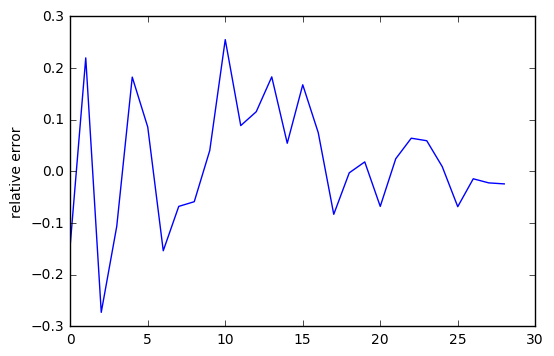

In [49]:
import matplotlib.pyplot as plt
plt.plot(lists[0])
plt.ylabel('relative error')
#plt.xlabel('crowd size (unit:500)')
plt.show()

In [50]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

#n = 50

x = np.array([r[0] for r in lists[2] ])
y = np.array([r[1] for r in lists[2] ])

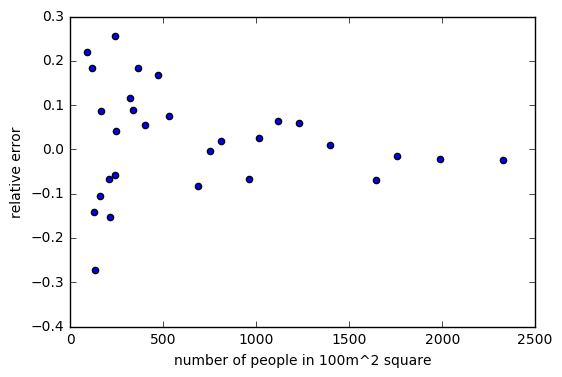

In [55]:
#fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg = 1)
#ax.plot(x, fit[0] * x + fit[1], color='red')
#ax.scatter(x, y)
#plt.show()


#plt.plot(x, fit[0] * x + fit[1], color='red')
plt.plot(0, color='red')
plt.scatter(x, y)
plt.ylabel('relative error')
plt.xlabel('number of people in 100m^2 square')
axes = plt.gca()
axes.set_xlim([0, 2500])
#axes.set_ylim([0,max(VisiblePerMinNonRandomized)])
plt.show()